In [ ]:
!pip install -q keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 924.6/924.6 kB 10.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import os
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

# Aquí se escoge el backend de keras
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'

import keras_core as keras

SEED = 42
keras.utils.set_random_seed(SEED)

In [ ]:
df_train = pd.read_csv("data/train_data.csv")
df_test = pd.read_csv("data/test_data.csv")
df_test2 = df_test.copy()

In [ ]:
df_train.head()

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,47.2857,-122.300,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,47.6885,-122.380,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,47.5150,-122.359,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,47.5758,-122.309,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,47.3531,-122.017,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0


In [ ]:
null_cols = []
for column in df_train.columns:
  if df_train[column].isnull().sum() > 0:
    print(column, ":", df_train[column].isnull().sum())
    null_cols.append(column)

bedrooms : 202
bathrooms : 197
sqft_living : 194
sqft_lot : 189
floors : 192
waterfront : 200
view : 194
condition : 181
grade : 190
sqft_above : 187
sqft_basement : 183
yr_built : 163
yr_renovated : 201
sqft_living15 : 189
sqft_lot15 : 196


In [ ]:
df_train.shape, df_test.shape

((1276, 21), (320, 20))

In [ ]:
df_train.describe()

,ID,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
count,1276.000000,1276.000000,1276.000000,1276.000000,1074.000000,1079.000000,1082.000000,1087.000000,1084.000000,1076.000000,1082.000000,1095.000000,1086.000000,1089.00000,1093.000000,1113.000000,1075.000000,1087.000000,1080.000000,1.276000e+03
mean,783.208464,98076.235110,47.567730,-122.207464,3.388268,2.148054,2140.665434,22913.940202,1.496771,0.011152,0.252311,3.398174,7.695212,1888.30303,279.931382,1971.873315,115.101395,2029.898804,18990.602778,5.610966e+05
std,459.141821,54.734005,0.137067,0.147224,0.937513,0.853977,977.118984,52877.670777,0.534790,0.105063,0.811640,0.654332,1.283757,919.42862,447.916340,28.587697,465.487096,760.953817,39235.248485,3.668160e+05
min,1.000000,98001.000000,47.162200,-122.511000,1.000000,0.000000,540.000000,638.000000,1.000000,0.000000,0.000000,1.000000,5.000000,530.00000,0.000000,1900.000000,0.000000,700.000000,1082.000000,7.800000e+04
25%,384.750000,98029.000000,47.492000,-122.339000,3.000000,1.500000,1420.000000,5383.000000,1.000000,0.000000,0.000000,3.000000,7.000000,1220.00000,0.000000,1953.000000,0.000000,1470.000000,5488.000000,3.262345e+05
50%,778.500000,98059.000000,47.588200,-122.215000,3.000000,2.250000,1990.000000,8145.000000,1.500000,0.000000,0.000000,3.000000,7.000000,1590.00000,0.000000,1971.000000,0.000000,1880.000000,8039.500000,4.675000e+05
75%,1182.250000,98117.000000,47.681300,-122.109750,4.000000,2.500000,2620.000000,14578.500000,2.000000,0.000000,0.000000,4.000000,8.000000,2400.00000,550.000000,1998.000000,0.000000,2440.000000,12263.000000,6.766250e+05
max,1592.000000,98199.000000,47.777500,-121.402000,10.000000,7.500000,7000.000000,715690.000000,3.000000,1.000000,4.000000,5.000000,12.000000,6370.00000,3500.000000,2015.000000,2015.000000,5790.000000,339332.000000,3.204000e+06


**Preprocessing**

bedrooms: media

bathrooms: media

sqft_living: media

sqft_lot: media

floors: moda

waterfront: 0

view: 0

condition: media

grade: media

sqft_above: media

sqft_basement: media

yr_built: media

yr_renovated: 0

sqft_living15: media

sqft_lot15: media

In [ ]:
# modificamos nuestras Coordenadas, debido a que se mueven en un rango pequeño

df_train["lat"] = df_train["lat"] - df_train["lat"].min()
df_test["lat"] = df_test["lat"] - df_test["lat"].min()

df_train["long"] = df_train["long"] - df_train["long"].min()
df_test["long"] = df_test["long"] - df_test["long"].min()

df_train

,ID,date,zipcode,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,...,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price
0,143,20140515T000000,98003,0.1235,0.211,3.0,2.25,1590.0,7748.0,2.0,...,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0
1,1175,20141203T000000,98117,0.5263,0.131,3.0,NaN,2040.0,4005.0,NaN,...,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0
2,221,20140711T000000,98106,0.3528,0.152,2.0,1.00,640.0,7768.0,1.0,...,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,NaN,7424.0,165000.0
3,1231,20141117T000000,98144,0.4136,0.202,2.0,1.50,1240.0,NaN,NaN,...,0.0,NaN,8.0,1080.0,160.0,NaN,0.0,1530.0,1209.0,403000.0
4,509,20150402T000000,98038,0.1909,0.494,3.0,NaN,1990.0,NaN,2.0,...,NaN,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,954,20150423T000000,98014,0.5198,0.598,3.0,2.50,3230.0,129578.0,1.0,...,0.0,NaN,NaN,2100.0,1130.0,NaN,0.0,2760.0,62059.0,499950.0
1272,104,20150507T000000,98103,0.5235,0.158,4.0,1.50,NaN,4000.0,1.5,...,2.0,NaN,7.0,1580.0,NaN,1920.0,1990.0,1160.0,4000.0,750000.0
1273,138,20140911T000000,98003,0.1205,0.209,3.0,NaN,NaN,6600.0,NaN,...,NaN,3.0,7.0,1610.0,0.0,NaN,0.0,1660.0,NaN,250000.0
1274,1529,20140509T000000,98075,0.4262,0.425,3.0,2.25,3000.0,11665.0,1.5,...,4.0,3.0,11.0,3000.0,0.0,2001.0,0.0,3000.0,15959.0,2400000.0


In [ ]:
# delete columns that doesn't give enough information
df_train = df_train.drop(columns = ["ID", "zipcode", "yr_renovated"])
df_test = df_test.drop(columns = ["ID", "zipcode", "yr_renovated"])

In [ ]:
df_train.columns

Index(['date', 'lat', 'long', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15',
       'sqft_lot15', 'price'],
      dtype='object')

<ipython-input-1435-201098802c09>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True)


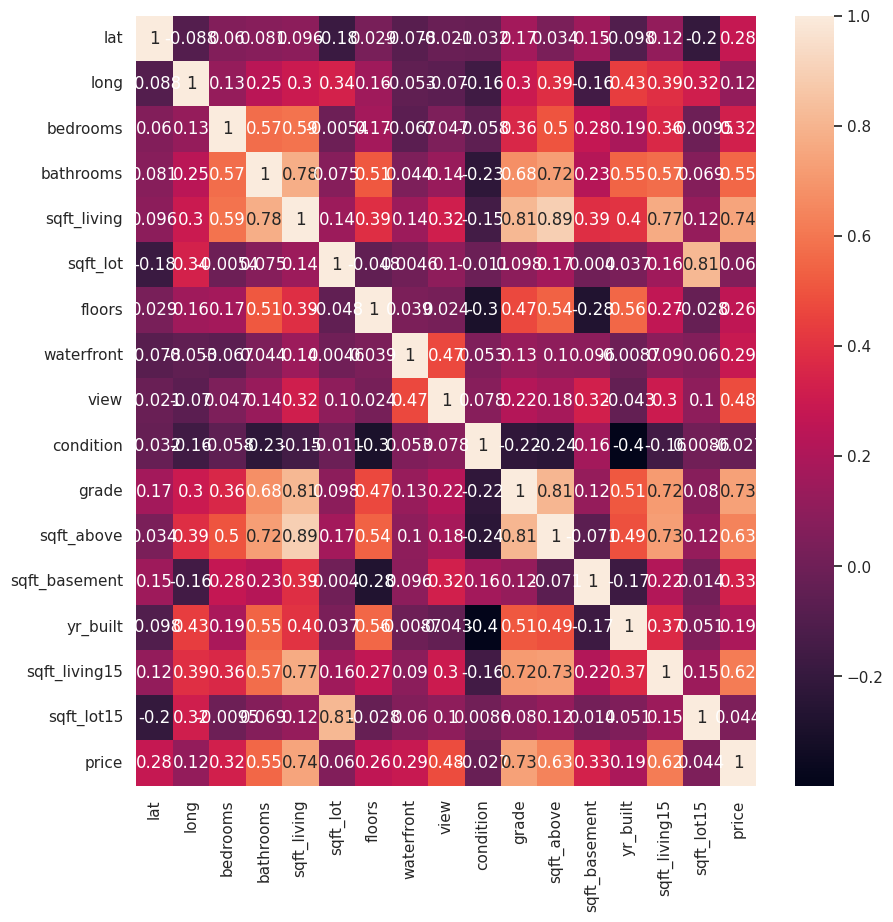

In [ ]:
sns.set (rc = {'figure.figsize':(10, 10)})
sns.heatmap(df_train.corr(), annot=True)
plt.show()

In [ ]:
# normalize data
min_max_scaler = MinMaxScaler()

cols_to_normalize = ['lat', 'long', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'sqft_living15',
       'sqft_lot15']

df_train[cols_to_normalize] = min_max_scaler.fit_transform(df_train[cols_to_normalize])
df_test[cols_to_normalize] = min_max_scaler.transform(df_test[cols_to_normalize])

In [ ]:
# llenamos las columnas correspondientes con 0's
# zero_cols = ['waterfront', 'view']
# df_train[zero_cols] = df_train[zero_cols].fillna(0)
# df_test[zero_cols] = df_test[zero_cols].fillna(0)

In [ ]:
# llenamos las columnas correspondientes con el promedio de la columna
median_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
             'condition', 'grade', 'sqft_above', 'sqft_basement',
             'yr_built', 'sqft_living15', 'sqft_lot15']

for col in median_cols:
  df_train[col] = df_train[col].fillna(df_train[col].median())
  df_test[col] = df_test[col].fillna(df_train[col].median())

In [ ]:
# llenamos la columna correspondiente con la moda de la columna
mode_cols = ['floors', 'waterfront', 'view']

for col in mode_cols:
  df_train[col] = df_train[col].fillna(df_train[col].mode()[0])
  df_test[col] = df_test[col].fillna(df_train[col].mode()[0])

df_train.head()

,date,lat,long,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,price
0,20140515T000000,0.200715,0.190261,0.222222,0.300000,0.162539,0.009943,0.5,0.0,0.0,0.75,0.285714,0.181507,0.000000,0.791304,0.174853,0.019288,263000.0
1,20141203T000000,0.855355,0.118124,0.222222,0.300000,0.232198,0.004709,0.0,0.0,0.0,0.75,0.428571,0.207192,0.085714,0.260870,0.133595,0.008642,620000.0
2,20140711T000000,0.573379,0.137060,0.111111,0.133333,0.015480,0.009971,0.0,0.0,0.0,0.50,0.142857,0.018836,0.000000,0.365217,0.231827,0.018749,165000.0
3,20141117T000000,0.672192,0.182146,0.111111,0.200000,0.108359,0.010499,0.0,0.0,0.0,0.50,0.428571,0.094178,0.045714,0.617391,0.163065,0.000375,403000.0
4,20150402T000000,0.310255,0.445446,0.222222,0.300000,0.224458,0.010499,0.5,0.0,0.0,0.50,0.285714,0.250000,0.000000,0.956522,0.369352,0.008035,318200.0


In [ ]:
# convert date
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y%M%dT000000')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y%M%dT000000')

df_train = df_train.drop('date',axis=1)
df_test = df_test.drop('date',axis=1)

In [ ]:
# Calculate z-score for each column
z_scores = np.abs(stats.zscore(df_train))

# Define threshold for outliers
threshold = 3

# Remove outliers
df_train = df_train[(z_scores < threshold).all(axis=1)]

### Data split in train and test

In [ ]:
y_train = df_train["price"]
X_train = df_train.drop(columns=["price"])
df_train.shape, df_test.shape

((1086, 17), (320, 16))

In [ ]:
inputs = keras.layers.Input(shape=(X_train.shape[1],))
# x1 = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(inputs)
# x1 = keras.layers.Dropout(0.2)(x1)
# x1 = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x1)
# x1 = keras.layers.Dropout(0.3)(x1)
# f1 = keras.layers.Flatten()(x1)

# x2 = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x1)
# x2 = keras.layers.Dropout(0.2)(x2)
# x2 = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x1)
# x2 = keras.layers.Dropout(0.3)(x2)
# f2 = keras.layers.Flatten()(x2)

# x3 = keras.layers.concatenate([f1, f2])
# x3 = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x3)
# x3 = keras.layers.Dropout(0.2)(x3)
# x3 = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x3)
# x3 = keras.layers.Dropout(0.3)(x3)
# output = keras.layers.Dense(1, activation='relu')(x3)

x = keras.layers.Dense(512, activation='relu', kernel_initializer="he_normal")(inputs)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
output = keras.layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Model: "functional_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_93 (InputLayer)     │ (None, 16)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_625 (Dense)               │ (None, 512)               │      8,704 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_313 (Dropout)           │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_626 (Dense)               │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_627 (Dense)               │ (None, 1024)              │    263,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_314 (Dropout)           │ (None, 1024)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_628 (Dense)               │ (None, 256)               │    262,400 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_629 (Dense)               │ (None, 1)                 │        257 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 665,857 (2.54 MB)

 Trainable params: 665,857 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=0.001)

model.compile(optimizer=opt, loss=loss, metrics=["mean_squared_error", "mean_absolute_error", "root_mean_squared_error"])

In [ ]:
### START CODE HERE ###
epochs = 400
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True #Es importante retornar los mejores pesos, por defecto viene en False asi que siempre asegurarse de ponerlo en True
    )
]

In [ ]:
### START CODE HERE ###
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=val_split,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 352ms/step - loss: 295798427648.0000 - mean_absolute_error: 490680.5547 - mean_squared_error: 295743025152.0000 - root_mean_squared_error: 543813.2969 - val_loss: 362128670720.0000 - val_mean_absolute_error: 532990.0000 - val_mean_squared_error: 357375606784.0000 - val_root_mean_squared_error: 597809.0000
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 295661240320.0000 - mean_absolute_error: 490548.6875 - mean_squared_error: 295607115776.0000 - root_mean_squared_error: 543688.3750 - val_loss: 361642819584.0000 - val_mean_absolute_error: 532562.0625 - val_mean_squared_error: 356892311552.0000 - val_root_mean_squared_error: 597404.6250
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 295007760384.0000 - mean_absolute_error: 489918.2891 - mean_squared_error: 294958034944.0000 - root_mean_squared_error: 543091.2969 - val_loss: 359805026304.0000 - val_mean_absolute_error: 530941.5625 - val_mean_squared_error: 355064348672.0000 - va

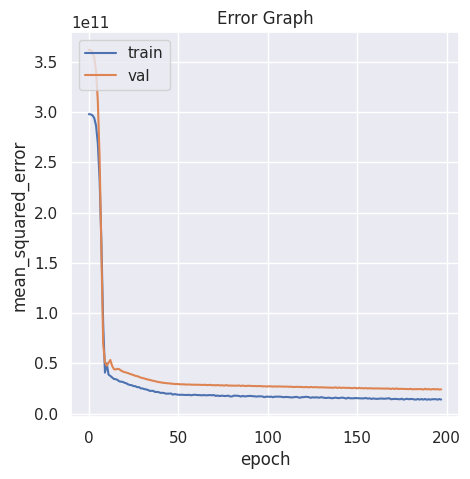

<Figure size 500x500 with 0 Axes>

In [ ]:
def plot_losses(history, loss):
  "Función para graficar la función de pérdida del modelo"
  plt.rcParams['figure.figsize'] = [5, 5]
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)

  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.figure(figsize=(5, 5))
  plt.show()

plot_losses(history, loss)

In [ ]:
model.save('house_pricesMSE27.keras')

In [ ]:
results = model.predict(df_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


In [ ]:
file = open('a.csv',"w")
file.write("ID,price\n")
for i in range(len(df_test2['ID'])):
  file.write(str(df_test2['ID'][i])+","+str(results[i][0])+"\n")
file.close()